<a href="https://colab.research.google.com/github/ParalelaUCM/biciMAD/blob/master/PracticaSpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup**

Instalamos y configuramos las herramientas necesarias para empezar a trabajar

In [1]:
!apt-get install openjdk-8-jdk
!apt install unzip
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!pip install pyspark

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libxxf86dga1 openjdk-8-jdk-headless openjdk-8-jre
  openjdk-8-jre-headless x11-utils
Suggested packages:
  openjdk-8-demo openjdk-8-source visualvm icedtea-8-plugin libnss-mdns
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic mesa-utils
The following NEW packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libxxf86dga1 openjdk-8-jdk openjdk-8-jdk-headless
  openjdk-8-jre openjdk-8-jre-headless x11-utils
0 upgraded, 10 newly installed, 0 to remove and 31 not upgraded.
Need to get 40.7 MB of archives.
After this operation, 153 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [1

In [2]:
!apt install unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


# **Descargamos los datasets de bicimad**
Descargaremos cada dataset de la web oficial) de biciMAD. Los renombraremos a '.zip' para poder descomprimirlos y una vez descomprimidos los movemos a la carpeta 'datasets'. Por último eliminamos los ficheros comprimidos.

In [0]:
#Carpeta para el dataset
!mkdir dataset

In [4]:
#Enero de 2019
!wget -N "https://opendata.emtmadrid.es/getattachment/2ebcc70a-4914-43c6-9ada-a0f0520032a4/201901_Usage_Bicimad.aspx"
!mv 201901_Usage_Bicimad.aspx 201901_Usage_Bicimad.zip
!unzip 201901_Usage_Bicimad.zip
!mv 201901_Usage_Bicimad.json dataset
!rm 201901_Usage_Bicimad.zip

--2020-05-25 17:25:43--  https://opendata.emtmadrid.es/getattachment/2ebcc70a-4914-43c6-9ada-a0f0520032a4/201901_Usage_Bicimad.aspx
Resolving opendata.emtmadrid.es (opendata.emtmadrid.es)... 185.79.130.130
Connecting to opendata.emtmadrid.es (opendata.emtmadrid.es)|185.79.130.130|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78311972 (75M) [application/zip]
Saving to: ‘201901_Usage_Bicimad.aspx’

201901_Usage_Bicima 100%[===================>]  74.68M  1.76MB/s    in 46s     

2020-05-25 17:26:30 (1.63 MB/s) - ‘201901_Usage_Bicimad.aspx’ saved [78311972/78311972]

Archive:  201901_Usage_Bicimad.zip
  inflating: 201901_Usage_Bicimad.json  


In [0]:
'''
#Febrero de 2019
!wget -N "https://opendata.emtmadrid.es/getattachment/aa8c34d2-ddba-46d9-b6db-882c0b4a12f0/201902_Usage_Bicimad.aspx"
!mv 201902_Usage_Bicimad.aspx 201902_Usage_Bicimad.zip 
!unzip 201902_Usage_Bicimad.zip
!mv 201902_Usage_Bicimad.json dataset
!rm 201902_Usage_Bicimad.zip
'''

'\n#Febrero de 2019\n!wget -N "https://opendata.emtmadrid.es/getattachment/aa8c34d2-ddba-46d9-b6db-882c0b4a12f0/201902_Usage_Bicimad.aspx"\n!mv 201902_Usage_Bicimad.aspx 201902_Usage_Bicimad.zip \n!unzip 201902_Usage_Bicimad.zip\n!mv 201902_Usage_Bicimad.json dataset\n!rm 201902_Usage_Bicimad.zip\n'

In [0]:

'''
#Junio de 2019
!wget -N "https://opendata.emtmadrid.es/getattachment/7517a650-ccdf-4ab1-b1b0-a1d13694472e/201906_Usage_Bicimad.aspx"
!mv 201906_Usage_Bicimad.aspx 201906_Usage_Bicimad.zip
!unzip 201906_Usage_Bicimad.zip
!mv 201906_Usage_Bicimad.json dataset
!rm 201906_Usage_Bicimad.zip
'''

'\n#Junio de 2019\n!wget -N "https://opendata.emtmadrid.es/getattachment/7517a650-ccdf-4ab1-b1b0-a1d13694472e/201906_Usage_Bicimad.aspx"\n!mv 201906_Usage_Bicimad.aspx 201906_Usage_Bicimad.zip\n!unzip 201906_Usage_Bicimad.zip\n!mv 201906_Usage_Bicimad.json dataset\n!rm 201906_Usage_Bicimad.zip\n'

# **Ahora ya podemos empezar**

In [0]:
sc.stop() # Esto lo he puesto aquí antes, porque he ido a ejecutar y me decia que ya habia uno, blablabla, pero que en teoría se puede quitar, vaya.

In [0]:
#Aquí ya podemos empezar a trabajar
import json
from pyspark import SparkContext
sc = SparkContext()

In [0]:
#Para usar dataFrames que puede ser interesante (No he usado nada de esto abajo)
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
df = spark.read.json("/content/dataset/201901_Usage_Bicimad.json")
df.show()

In [0]:
rdd_raw  = sc.textFile('/content/dataset/201901_Usage_Bicimad.json')

In [8]:
rdd_raw.take(1)

['{ "_id" : { "$oid" : "5c4b07ea2f38432e007daab8" }, "user_day_code" : "b3b5b61509ab89afbf4d1e589d229bebe6637c2de819f5d612762c939b8d7f1f", "idplug_base" : 14, "track" : { "type" : "FeatureCollection", "features" : [ { "geometry" : { "type" : "Point", "coordinates" : [ -3.6803143, 40.4048615 ] }, "type" : "Feature", "properties" : { "var" : "28007,ES,Madrid,Madrid,AVDA MENENDEZ PELAYO 117,Madrid", "speed" : 1.77, "secondsfromstart" : 153 } }, { "geometry" : { "type" : "Point", "coordinates" : [ -3.67770349972222, 40.4029987997222 ] }, "type" : "Feature", "properties" : { "var" : "28007,ES,Madrid,Madrid,AVDA CIUDAD DE BARCELONA 51,Madrid", "speed" : 6.58, "secondsfromstart" : 93 } }, { "geometry" : { "type" : "Point", "coordinates" : [ -3.67432209972222, 40.4009430997222 ] }, "type" : "Feature", "properties" : { "var" : "28007,ES,Madrid,Madrid,AVDA CIUDAD DE BARCELONA 81,Madrid", "speed" : 4.72, "secondsfromstart" : 32 } } ] }, "user_type" : 1, "idunplug_base" : 23, "travel_time" : 162, 

### **Analisis y comparativas entre datos nocturnos y diurnos**

In [0]:
def mapper(line):
  data = json.loads(line)
  user = data['user_type']
  user_day = data['user_day_code']
  start = data['idunplug_station']
  end = data['idplug_station']
  date = data['unplug_hourTime']['$date'][0:10]
  hora = data['unplug_hourTime']['$date'][11:19]
  time = data['travel_time']
  return user, user_day, start, end , time, date, hora 

In [0]:
def horasNocturnas(line):
  data = json.loads(line)
  hora_minima = 3600 #Esto seria pasar las 01:00:00 horas a segundos‬
  hora_maxima = 18000 #Esto seria pasar las 05:00:00 horas a segundos‬
  hora = data['unplug_hourTime']['$date'][11:19]
  hora_actual = int(hora[0:2]) * 3600 + int(hora[3:5]) * 60 + int(hora[6:8])
  #En teoria con multipicar solo las horas ya valdria porque no hay ni minutos ni segundos
  return hora_minima <= hora_actual <= hora_maxima
rddNocturna = rdd_raw.filter(lambda x: horasNocturnas(x))

In [0]:
rddNocturna.take(1)

In [12]:
#Separamos ahora por tipo de usuario y vemos cuantos hay de cada tipo en total en todo el mes(para caso nocturno)
rddNocturna_datos = rddNocturna.map(mapper)
night_data = rddNocturna_datos.countByKey()
night_data

defaultdict(int, {0: 157, 1: 13843, 2: 132, 3: 2432})

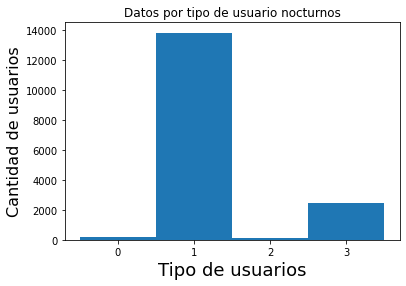

In [21]:
import matplotlib.pyplot as plt
plt.title('Datos por tipo de usuario nocturnos')
names = list(night_data.keys()) 
values = list(night_data.values())
plt.bar(names, values, 1)
plt.xlabel('Tipo de usuarios', fontsize=18)
plt.ylabel('Cantidad de usuarios', fontsize=16)
names.sort()
plt.xticks(names, ["0","1","2","3"])
plt.show()

Podemos observar como la mayoría de usuarios que han usado bicimad por la noche son usuarios del tipo 1, que son los usuarios anuales mientras que hay muy pocos usuarios ocasionales. Veamos una comparación con los datos diurnos.

In [0]:
def horasDiurnas(line):
  data = json.loads(line)
  hora_minima = 18000 #Esto seria pasar las 05:00:00 horas a segundos‬
  hora = data['unplug_hourTime']['$date'][11:19]
  hora_actual = int(hora[0:2]) * 3600 + int(hora[3:5]) * 60 + int(hora[6:8])
  #En teoria con multipicar solo las horas ya valdria porque no hay ni minutos ni segundos
  return hora_minima < hora_actual
rddDiurna = rdd_raw.filter(lambda x: horasDiurnas(x))

In [17]:
rddDiurna.take(1)

['{ "_id" : { "$oid" : "5c4b07ef2f38432e007dae95" }, "user_day_code" : "963823d9e2087febb35ccffa49f4311dc679dede68cc5aafe7a385f24009575d", "idplug_base" : 5, "track" : { "type" : "FeatureCollection", "features" : [ { "geometry" : { "type" : "Point", "coordinates" : [ -3.6910045, 40.4080585997222 ] }, "type" : "Feature", "properties" : { "var" : "28007,ES,Madrid,Madrid,AVDA CIUDAD DE BARCELONA 2D,Madrid", "speed" : 7.27, "secondsfromstart" : 314 } }, { "geometry" : { "type" : "Point", "coordinates" : [ -3.69283509972222, 40.4106409997222 ] }, "type" : "Feature", "properties" : { "var" : "28014,ES,Madrid,Madrid,PASEO PRADO 38,Madrid", "speed" : 7.5, "secondsfromstart" : 254 } }, { "geometry" : { "type" : "Point", "coordinates" : [ -3.6943575, 40.4149359997222 ] }, "type" : "Feature", "properties" : { "var" : "28014,ES,Madrid,Madrid,PASEO PRADO,Madrid", "speed" : 8, "secondsfromstart" : 194 } }, { "geometry" : { "type" : "Point", "coordinates" : [ -3.69392699972222, 40.4191884997222 ] }, 

In [19]:
#Separamos ahora por tipo de usuario y vemos cuantos hay de cada tipo en total en todo el mes(para caso diurno)
rddDiurna_datos = rddDiurna.map(mapper)
day_data = rddDiurna_datos.countByKey()
day_data

defaultdict(int, {0: 1646, 1: 233460, 2: 1793, 3: 18328})

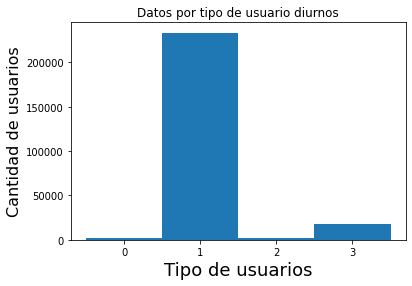

In [20]:
plt.title('Datos por tipo de usuario diurnos')
names = list(day_data.keys()) 
values = list(day_data.values())
plt.bar(names, values, 1)
plt.xlabel('Tipo de usuarios', fontsize=18)
plt.ylabel('Cantidad de usuarios', fontsize=16)
names.sort()
plt.xticks(names, ["0","1","2","3"])
plt.show()

Los datos de los histogramas son muy parecidos por lo que para ver la diferencia entre los datos nocturnos y los diurnos, es necesario hacer una proporcion para ver como son estos datos

In [22]:
#Proporcion datos nocturnos
print("Proporción entre tipo 2 sobre tipo 1: ", 132/13843)

Proporción entre tipo 2 sobre tipo 1:  0.00953550530954273


In [23]:
#Proporcion datos diurnos
print("Proporción entre tipo 2 sobre tipo 1: ", 1793/233460)

Proporción entre tipo 2 sobre tipo 1:  0.007680116508181273


Las proporciones son muy parecidas por lo que podriamos considerar que no afecta en gran medida el tipo de usuarios dependiendo de las horas

### **Analisis profundo de datos nocturnos**

Veamos ahora, los fines de semana. Si nos vamos a enero de 2019, los fines de semana (viernes-domingo) fueron los días, 4,5,6,11,12,13,18,19,20,25,26,27.


In [0]:
def weekend(line):
  #Como en realidad queremos las noches, 'la noche del vierne' sería el sabado ya, entonces, buscamos los
  #días: 5,6,7,12,13,14,19,20,21,26,27,28.
  data=json.loads(line)
  days=['2019-01-05', '2019-01-06', '2019-01-07','2019-01-12','2019-01-13','2019-01-14', '2019-01-19', '2019-01-20','2019-01-21','2019-01-26', '2019-01-27', '2019-01-28']
  dia_actual=data['unplug_hourTime']['$date'][0:10]
  return dia_actual in days

In [65]:
rddWeekend=rddNocturna.filter(lambda x: weekend(x))
rddWeekend_datos=rddWeekend.map(mapper)
weekend_data=rddWeekend_datos.countByKey()
weekend_data

defaultdict(int, {0: 129, 1: 8225, 2: 83, 3: 913})

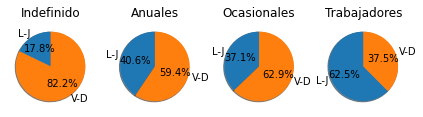

In [0]:
fig=plt.figure()
fig.subplots_adjust(bottom=0.025, left=0.05, top = 0.975, right=0.975)
fig.add_subplot(1,4,1)
plt.pie([night_data[0]-weekend_data[0], weekend_data[0]], labels=['L-J', 'V-D'],
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Indefinido')
fig.add_subplot(1,4,2)
plt.pie([night_data[1]-weekend_data[1], weekend_data[1]], labels=['L-J', 'V-D'],
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Anuales')
fig.add_subplot(1,4,3)
plt.pie([night_data[2]-weekend_data[2], weekend_data[2]], labels=['L-J', 'V-D'],
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Ocasionales')
fig.add_subplot(1,4,4)
plt.pie([night_data[3]-weekend_data[3], weekend_data[3]], labels=['L-J', 'V-D'],
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Trabajadores')
#plt.legend(['entre semana', 'fin de semana'], loc=4)
plt.show()

Como vemos, más de la mitad de viajeros ordinarios nocturnos, utilizan BiciMad en el fin de semana, incluso más del 60% en los viajeros ocasionales. Sin embargo, de los trabajadores de la empresa, solo el 37% lo hace en fin de semana.


Veamos ahora, los movimientos por horas.


In [66]:
def movimientosPorHoras(line):
  data= json.loads(line)
  hora= data['unplug_hourTime']['$date'][11:19]
  user=data['user_type']
  return hora, user
rddHoras=rddNocturna.map(movimientosPorHoras)
time_data=rddHoras.countByKey()
time_data

defaultdict(int,
            {'01:00:00': 5521,
             '02:00:00': 4394,
             '03:00:00': 2612,
             '04:00:00': 2207,
             '05:00:00': 1830})

In [67]:
rddHorasWeekend=rddWeekend.map(movimientosPorHoras)
weekend_time_data = rddHorasWeekend.countByKey()
weekend_time_data

defaultdict(int,
            {'01:00:00': 2812,
             '02:00:00': 2453,
             '03:00:00': 1684,
             '04:00:00': 1396,
             '05:00:00': 1005})

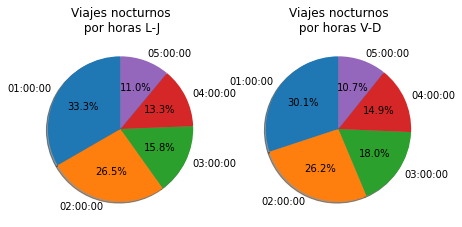

In [0]:
fig=plt.figure()
fig.subplots_adjust(bottom=0.025, left=0.05, top = 0.975, right=0.975)
fig.add_subplot(1,2,1)
plt.pie(list(time_data.values()), labels=list(time_data.keys()),
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Viajes nocturnos\n por horas L-J')
fig.add_subplot(1,2,2)
plt.pie(list(weekend_time_data.values()), labels=list(weekend_time_data.keys()),
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Viajes nocturnos\n por horas V-D')
plt.show()

Como vemos, en ambos casos, la mayoría de viajes se producen entre la 1 y las 3 de la madrugada, quizás se deba a que a partir de una cierta hora, sea más seguro otro tipo de transporte que la bici.
Durante el fin de semana, baja el tanto porciento de viajes entre la 1 y las 2 en un 3,2% y sin embargo, hay un incremento entre las 3 y las 4 del 2,2%, y entre las 4 y las 5 del 1,6%.

Para entenderlo mejor, veamos también distinciones por horas y usuarios.

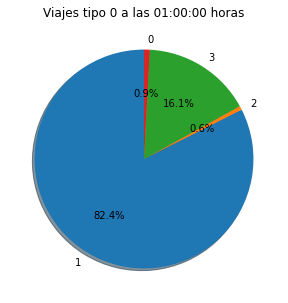

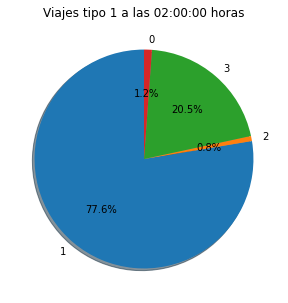

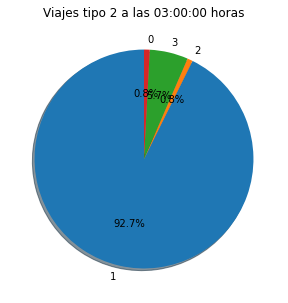

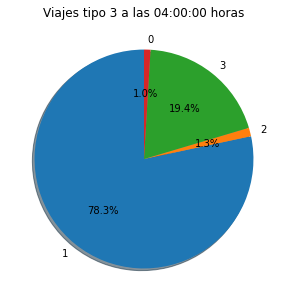

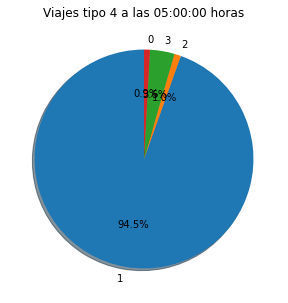

In [100]:
horas = ['01:00:00', '02:00:00', '03:00:00', '04:00:00', '05:00:00']
#fig=plt.figure()
#fig.subplots_adjust(bottom=0.025, left=0.05, top = 0.975, right=0.975) 
#fig.add_subplot(3,5,1)
def grafica(dic, value):
  fig=plt.figure()
  fig.subplots_adjust(bottom=0.025, left=0.05, top = 0.975, right=0.975) 
  #linea = value/2 +1
  #pos = (value % 2) + 1
  #fig.add_subplot(linea,5,pos)
  plt.pie(list(dic.values()), labels=list(dic.keys()),
        autopct='%1.1f%%', shadow=True, startangle=90)
  plt.title('Viajes tipo '+str(value)+' a las '+horas[value]+' horas')
  plt.show()
for i in range(5):
  grafica(rddHoras.filter(lambda x: x[0] == horas[i]).map(lambda x: (x[1], 1)).countByKey(), i)
#Tarda un rato y he intentado ponerlo como lo ponia elisa pero quedaba muy pequeño y no se absolutamente nada. Asi se ve mas pero a lo mejor
#ocupa demasiado.

Esto de aqui abajo lo he hecho pero no sabia por que y lo he dejado asi jaja

In [57]:
#Esta RDD ya tiene los datos importantes usando la funcion mapper        
rddNocturna_ordenada = rddNocturna_datos.map(lambda x: (x[2], 1)).groupByKey().mapValues(tuple).map(lambda x: (len(x[1]), x[0]))
rddNocturna_ordenada.sortByKey(False).map(lambda x: (x[1], x[0])).take(1)

[(57, 366)]

La estacion de la que parten mas bicis es de la 57, veamos que estaciones tienen como destino

In [0]:
rddNocturna_datos.filter(lambda x: x[2] == 57).map(lambda)